In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
class Dmd:
    def __init__(self, tilt_angle, mirror_size, mirror_gap, nr_x, nr_sources_per_mirror) -> None:
        self.tilt_angle_deg = tilt_angle
        self.tilt_angle_rad = np.deg2rad(tilt_angle)
        self.mirror_size = mirror_size
        self.mirror_gap = mirror_gap
        self.mirror_coords_x = np.linspace(0, mirror_size, nr_sources_per_mirror)
        self.mirror_coords_y = np.zeros(nr_sources_per_mirror)
        self.nr_x = nr_x
        self.nr_sources_per_mirror = nr_sources_per_mirror
        self.nr_sources_total = nr_x * nr_sources_per_mirror
        self.width = (mirror_size + mirror_gap) * nr_x - mirror_gap

    # check that values don't pass the boundaries
    def check_values(self, nr_x, s):
        if (s < 0) or (s > self.mirror_size): raise ValueError(f"Parameter s has to be inside [0, {self.mirror_size}], but value is {s}.")
        if (nr_x < 0) or (nr_x >= self.nr_x): raise ValueError(f"Parameter nr_x has to be inside [0, {self.nr_x}), but value is {nr_x}.")
    
    # calculate rotated x coordinate
    def get_x(self, nr_x, s):
        self.check_values(nr_x, s)
        cos = np.cos(self.tilt_angle_rad)
        mirror_edge = (self.mirror_size + self.mirror_gap) * nr_x - self.width / 2
        mirror_middle = self.mirror_size / 2.0
        x = mirror_edge + (s - mirror_middle) * cos + mirror_middle
        return x

    # calculate rotated y coordinate
    def get_y(self, nr_x, s):
        self.check_values(nr_x, s)
        sin = np.sin(self.tilt_angle_rad)
        mirror_middle = self.mirror_size / 2.0
        y = (s - mirror_middle) * sin
        return y
    
    def get_phase_shift_old(self, nr_x, s, k, incident_angle_rad):
        return k * (self.get_x(nr_x, s) * np.cos(incident_angle_rad) + self.get_y(nr_x, s) * np.sin(incident_angle_rad))
    
    def get_projection(self, nr_x, k, incident_angle_rad):
        r_p = np.array([
            self.get_x(nr_x, self.mirror_coords_x[0]) - self.get_x(nr_x, self.mirror_coords_x[-1]),
            self.get_y(nr_x, self.mirror_coords_x[0]) - self.get_y(nr_x, self.mirror_coords_x[-1])])
        r_p_norm = r_p/np.linalg.norm(r_p)
        k_vector = k * np.array([np.cos(incident_angle_rad), np.sin(incident_angle_rad)])
        return np.dot(k_vector, r_p_norm) * r_p_norm
    
    def get_phase_shift(self, nr_x, s, k_proj):
        r = np.array([self.get_x(nr_x, s), self.get_y(nr_x, s)])
        return np.dot(k_proj, r)
    
    def display_dmd(self):
        

        for nr_x in range(self.nr_x):
            plt.plot([self.get_x(nr_x, s) for s in self.mirror_coords_x], [self.get_y(nr_x, s) for s in self.mirror_coords_x])


        plt.title("Surface of the dmd")
        plt.axis("equal")
        plt.axhline(0, linestyle="dotted", zorder=-1, color="gray")
        plt.tight_layout()
        plt.show()


In [3]:
class Simulation:
    def __init__(self, dmd:Dmd, incident_angle, wavelength, field_dimensions: tuple, res, source_type) -> None:
        self.dmd = dmd
        self.k = 2 * np.pi / wavelength
        self.res = res
        self.pixels_x = res * field_dimensions[0]
        self.pixels_y = res * field_dimensions[1]
        self.incident_angle_deg = incident_angle
        self.incident_angle_rad = np.deg2rad(incident_angle)

        # define the range where the field should be calculated
        self.x_range = np.linspace(-field_dimensions[0]/2, field_dimensions[0]/2, self.pixels_x)
        self.y_range = np.linspace(0, field_dimensions[1], self.pixels_y) - self.dmd.mirror_size/2
        self.X, self.Y = np.meshgrid(self.x_range, self.y_range)

        self.E_incident = np.exp(1j * self.k * (self.X * np.cos(self.incident_angle_rad) + self.Y * np.sin(self.incident_angle_rad)))


    def get_E_total(self):
        epsilon = 1e-10
        E_total = np.zeros_like(self.X, dtype=complex)

        for nr_x in range(self.dmd.nr_x):
            k_proj = self.dmd.get_projection(nr_x, self.k, self.incident_angle_rad)
            for s in self.dmd.mirror_coords_x:
                r = np.sqrt(np.square(self.X - self.dmd.get_x(nr_x, s)) + np.square(self.Y - self.dmd.get_y(nr_x, s)))
                phase_shift = self.dmd.get_phase_shift(nr_x, s, k_proj)
                #phase_shift = self.dmd.get_phase_shift_old(nr_x, s, self.k, self.incident_angle_rad)
                E_reflected = np.exp(1j * (self.k * r + phase_shift)) / (r + epsilon)
                E_total += E_reflected
        
        return E_total

    def display_field(self, E_total):
        # Plotting
        plt.figure(figsize=(12, 6))

        # Plot the real part of the total reflected field
        plt.subplot(1, 2, 1)
        plt.contourf(self.X, self.Y, np.log(np.abs(E_total)), levels=50, cmap='viridis')
        plt.title('abs(E_total)')
        plt.xlabel('x')
        plt.ylabel('y')

        # Plot the imaginary part of the total reflected field
        plt.subplot(1, 2, 2)
        # plt.contourf(x, y, np.imag((E_total)), levels=50, cmap='plasma')
        plt.contourf(self.X, self.Y, np.imag((self.E_incident)), levels=50, cmap='plasma')
        # plt.colorbar(label='Incident Field Real')
        plt.title('Imag(E_in)')
        plt.xlabel('x')
        plt.ylabel('y')

        plt.tight_layout()
        plt.show()



# Dmd setup (Test)

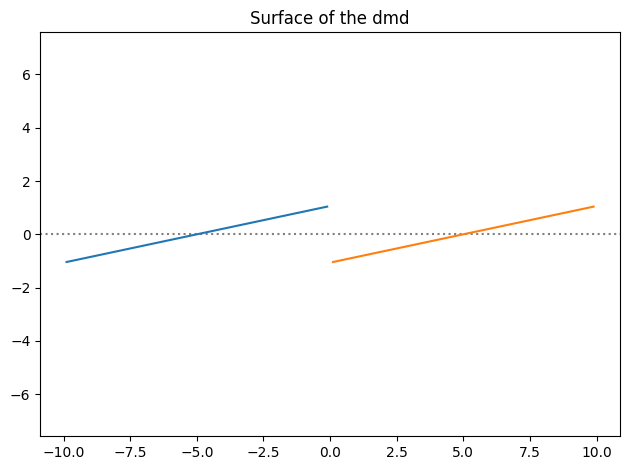

In [8]:
dmd_test = Dmd(12, 10, 0, 2, 10)
dmd_test.display_dmd()

# Simulation setup

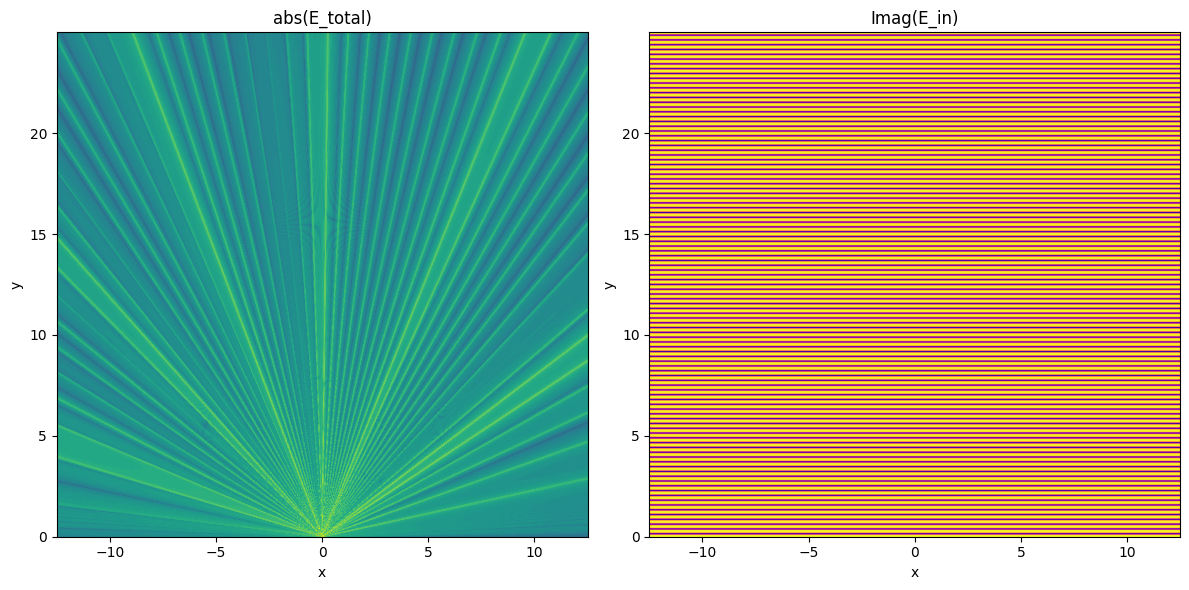

In [9]:
# initiate dmd
dmd = Dmd(tilt_angle=12,
           mirror_size=13.7e-6, 
           mirror_gap=0.1e-6, 
           nr_x=30,
           nr_sources_per_mirror=10)

# initiate simulation
sim = Simulation(dmd=dmd,
                 incident_angle=90,
                 wavelength=532e-9,
                 field_dimensions=(25, 25),
                 res=50,
                 source_type="spherical")

E_total = sim.get_E_total()
sim.display_field(E_total)